# Exploratory Data Analysis (EDA)
The purpose of this notebook is to explore the underlying structure, distributions, and relationships within the dataset. The insights gained from this analysis will inform data cleaning, preprocessing decisions, and model selection for the regression task of predicting the outcome variable.


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [117]:
df = pd.read_csv("../data/CW1_train.csv")

## 1. Overview of the Dataset

In [118]:
print("Dataset shape:", df.shape)

numerical_features = df.select_dtypes(include='number').columns.tolist()
categorical_features = df.select_dtypes(exclude='number').columns.tolist()

print(f"Number of numerical features: {len(numerical_features)}")
print(f"Number of categorical features: {len(categorical_features)}")

print("\nNumerical features:")
print(numerical_features)

print("\nCategorical features:")
print(categorical_features)

print("\nTarget (outcome) summary:")
print(df["outcome"].describe())


Dataset shape: (10000, 31)
Number of numerical features: 28
Number of categorical features: 3

Numerical features:
['outcome', 'carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']

Categorical features:
['cut', 'color', 'clarity']

Target (outcome) summary:
count    10000.000000
mean        -4.979081
std         12.722224
min        -44.879471
25%        -13.989962
50%         -5.442794
75%          3.918593
max         39.675966
Name: outcome, dtype: float64


The dataset contains 10,000 samples and 31 features, split into 28 numerical features and 3 categorical variables. The target variable *outcome* is continuous, confirming this as a regression task

## 2. Distribution of the Target Variable

Skewness of outcome: 0.0831


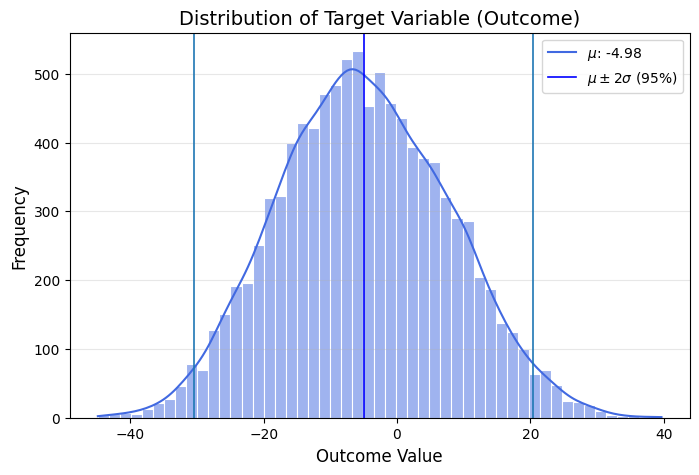

In [139]:
plt.figure(figsize=(8, 5))

mu = df["outcome"].mean()
sigma = df["outcome"].std()
skewness = df["outcome"].skew()

print(f"Skewness of outcome: {skewness:.4f}")

sns.histplot(df["outcome"], kde=True, color="royalblue", edgecolor="white")

plt.title("Distribution of Target Variable (Outcome)", fontsize=14)
plt.xlabel("Outcome Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.3)

plt.axvline(x=mu, color="blue", linewidth=1.2)

plt.axvline(x=mu + 2*sigma, linewidth=1.2)
plt.axvline(x=mu - 2*sigma, linewidth=1.2)

plt.legend([
    rf"$\mu$: {mu:.2f}", 
    r"$\mu \pm 2\sigma$ (95%)"
])


plt.savefig("../figures/target_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

The distribution of the target variable, outcome, is approximately normal, exhibiting a symmetric, bell-shaped profile centered at a mean ($\mu$) of −4.98. This visual observation is supported quantitatively by a very low skewness value (skew ≈ 0.08), indicating minimal asymmetry in the distribution. To assess the spread and potential presence of outliers, thresholds at two standard deviations ($\pm 2\sigma$) were plotted, which capture approximately 95% of the data under a Gaussian assumption. Frequencies taper smoothly toward both tails, with extreme values around −40 and +40 remaining consistent with the natural spread of the distribution rather than appearing as isolated anomalies. These observations confirm that the target variable is well-suited for regression modelling without requiring further mathematical transformations such as logarithmic scaling.

## 3. Data Quality Checks

In [120]:
print("Missing values per column:")
print(df.isnull().sum())

print("Number of duplicate rows:", df.duplicated().sum())

Missing values per column:
outcome    0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
a1         0
a2         0
a3         0
a4         0
a5         0
b1         0
b2         0
b3         0
b4         0
b5         0
a6         0
a7         0
a8         0
a9         0
a10        0
b6         0
b7         0
b8         0
b9         0
b10        0
dtype: int64
Number of duplicate rows: 0


In [121]:
print("Number of zero values in dimensions:")
print((df[["x", "y", "z"]] == 0).sum())

print("Summary statistics for dimensions:")
print(df[["x", "y", "z"]].describe())

Number of zero values in dimensions:
x    2
y    2
z    4
dtype: int64
Summary statistics for dimensions:
                  x             y             z
count  10000.000000  10000.000000  10000.000000
mean       5.733974      5.741665      3.540757
std        1.114850      1.228057      0.692502
min        0.000000      0.000000      0.000000
25%        4.730000      4.740000      2.920000
50%        5.700000      5.720000      3.530000
75%        6.530000      6.530000      4.030000
max       10.010000     58.900000      8.060000


Physical dimensions cannot be zero. These rows were identified as data errors

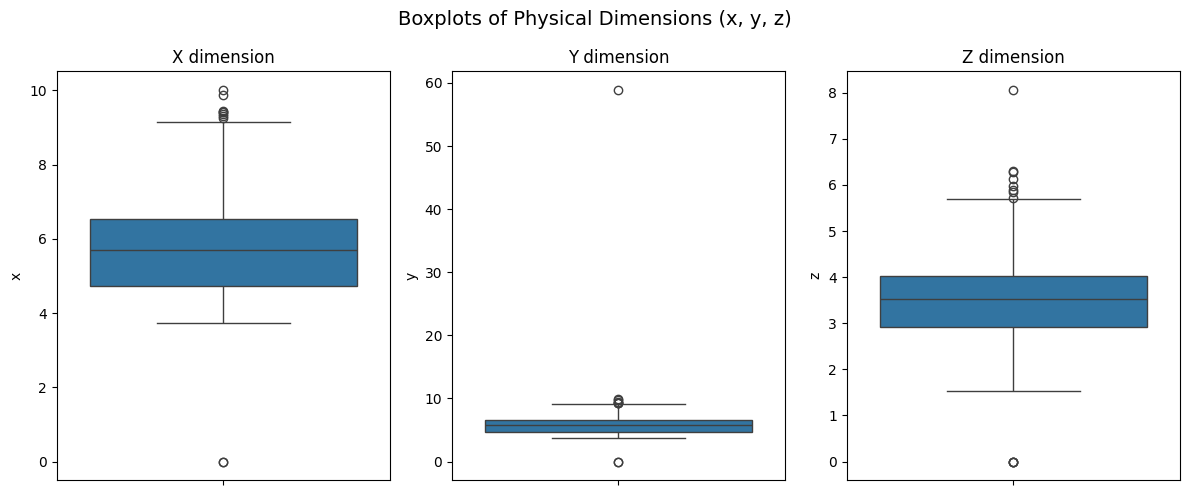

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.boxplot(data=df["x"], ax=axes[0])
axes[0].set_title("X dimension")

sns.boxplot(data=df["y"], ax=axes[1])
axes[1].set_title("Y dimension")

sns.boxplot(data=df["z"], ax=axes[2])
axes[2].set_title("Z dimension")

fig.suptitle("Boxplots of Physical Dimensions (x, y, z)", fontsize=14)
plt.tight_layout()
plt.savefig("../figures/dimension_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

The dataset contained no missing or duplicate records. However, summary statistics and boxplots of the physical dimension features ($x$, $y$, $z$) revealed the presence of physically impossible zero values, as well as an extreme outlier in the $y$ dimension (y goes to 60). These observations suggest potential data entry errors or measurement anomalies and were investigated prior to further analysis.

## 4. Correlation Structure & Multicollinearity

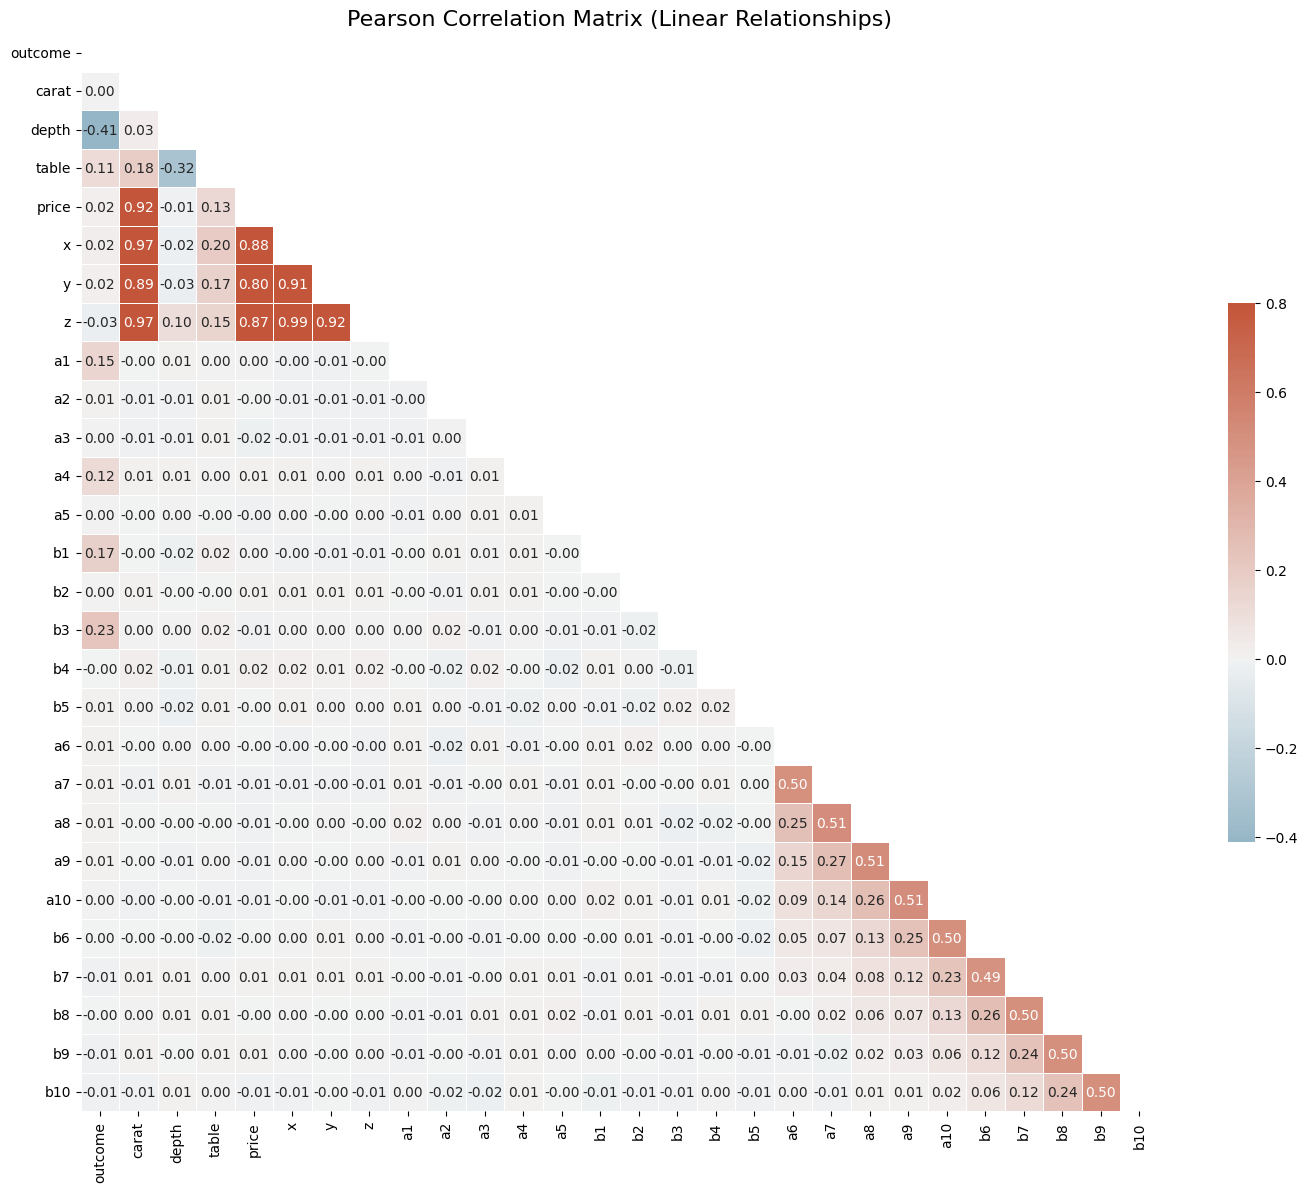

In [141]:
numerical_features = df.select_dtypes(include="number")

correlation_matrix = numerical_features.corr(method="pearson")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, axes = plt.subplots(figsize=(18, 14))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap=cmap, 
    vmax=.8, 
    center=0,       
    square=True, 
    linewidths=.5,
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": .5}
)

plt.title("Pearson Correlation Matrix (Linear Relationships)", fontsize=16)
plt.savefig("../figures/correlation_heatmap.png", bbox_inches='tight', dpi=300)
plt.show()

Pearson correlation is used here to identify linear relationships and potential multicollinearity between predictors

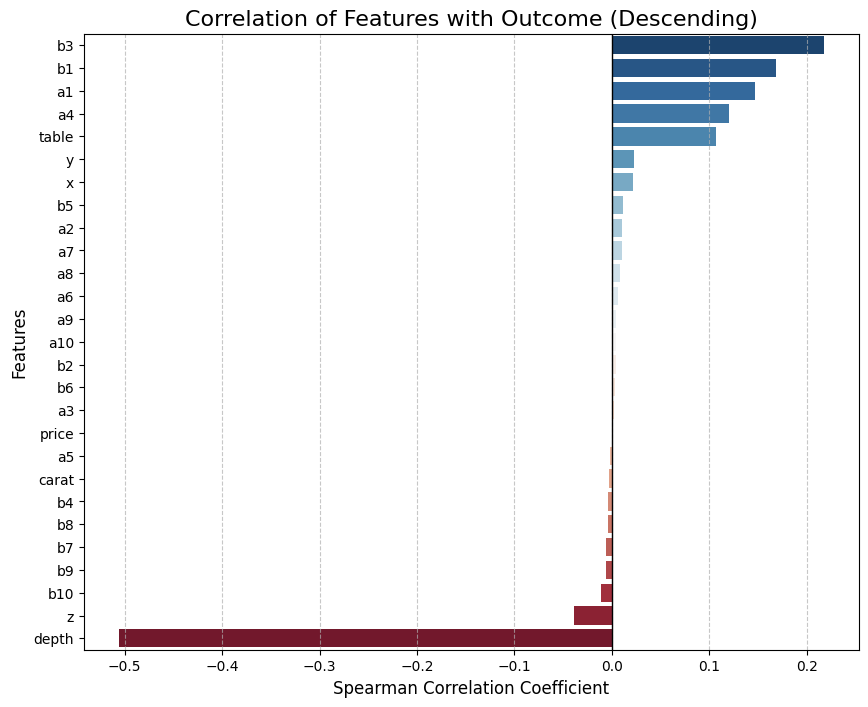

In [124]:
correlations = numerical_features.corr(method="spearman")["outcome"].drop("outcome").sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, hue=correlations.index, palette='RdBu_r', legend=False)

plt.title("Correlation of Features with Outcome (Descending)", fontsize=16)
plt.xlabel("Spearman Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.axvline(x=0, color="black", linestyle="-", linewidth=1)
plt.grid(axis="x", linestyle="--", alpha=0.7)


plt.savefig("../figures/target_correlations_bar.png", bbox_inches="tight", dpi=300)
plt.show()

Spearman colleration is used here to capture relationships between features and the outcome without assuming linearity. The top 5 features by absolute Spearman correlation are plotted against the outcome in the next section

In [125]:
n = 5
numerical_features = df.select_dtypes(include="number")
correlation = numerical_features.corr(method="spearman")["outcome"].drop("outcome")
top_features = correlation.abs().sort_values(ascending=False).head(n)
print(f"Top {n} features by Spearman correlation with outcome:")
print(correlation[top_features.index])

Top 5 features by Spearman correlation with outcome:
depth   -0.505889
b3       0.217254
b1       0.168709
a1       0.146819
a4       0.120144
Name: outcome, dtype: float64


## 5. Relationship between Important Features and Outcome

We now plot outcome against the top 5 feature by absolute Spearman correlation to visually assess the nature of these relationships.

In [126]:
def plot_feature_vs_outcome(feature: str):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y="outcome", data=df, alpha=0.5)
    sns.regplot(x=feature, y="outcome", data=df, scatter=False, color="red")
    plt.title(f"Scatter Plot of {feature} vs Outcome")
    plt.xlabel(feature)
    plt.ylabel("Outcome")
    plt.savefig(f"../figures/scatter_plot_{feature}_vs_outcome.png", dpi=300, bbox_inches="tight")
    plt.show()

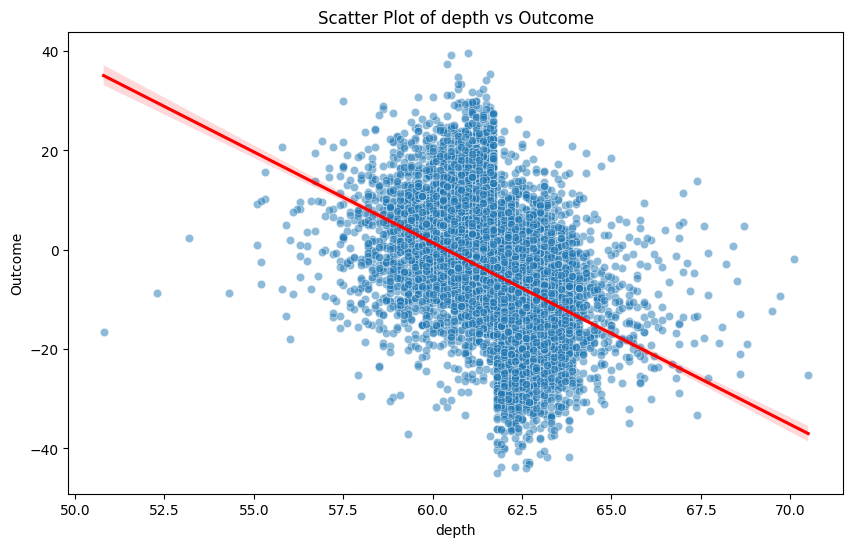

In [127]:
plot_feature_vs_outcome("depth")

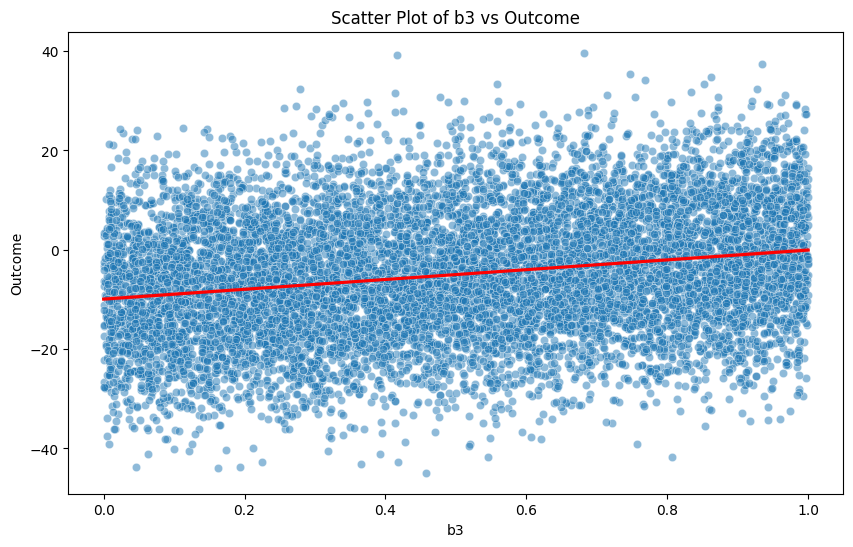

In [128]:
plot_feature_vs_outcome("b3")

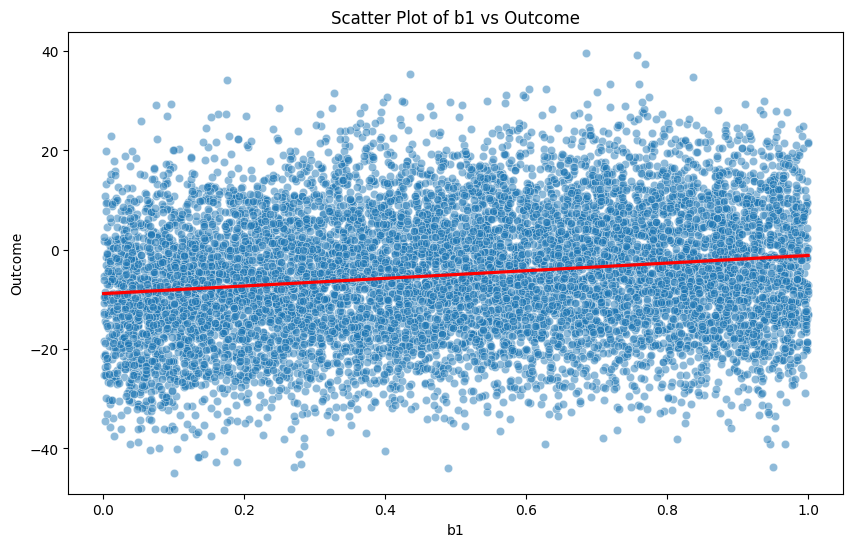

In [129]:
plot_feature_vs_outcome("b1")

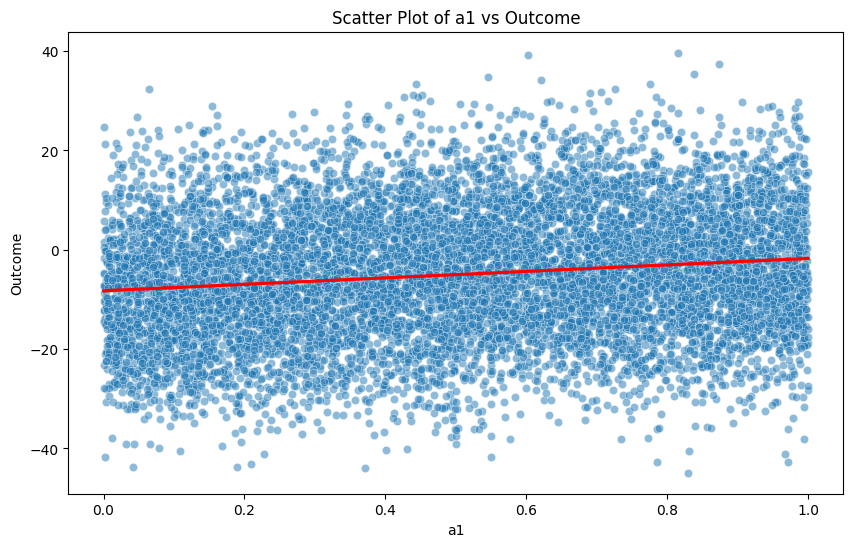

In [130]:
plot_feature_vs_outcome("a1")

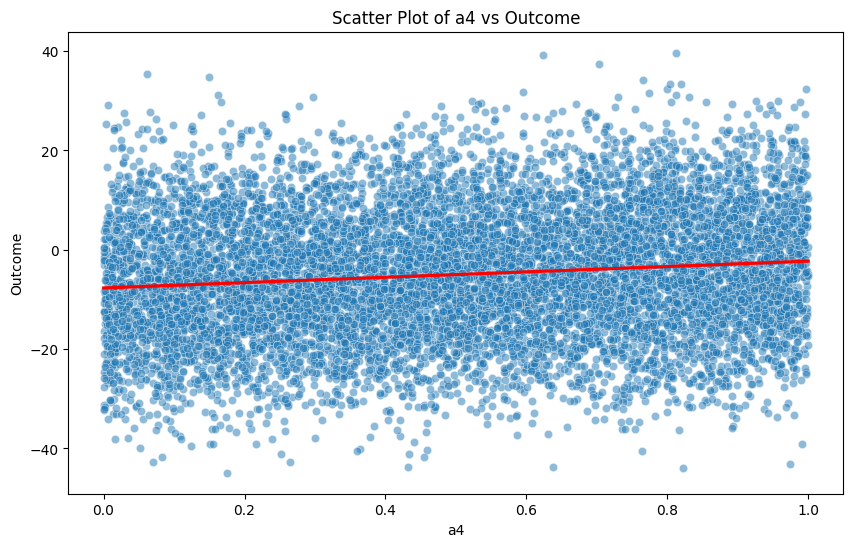

In [131]:
plot_feature_vs_outcome("a4")

## 6. Categorical Features vs Outcome

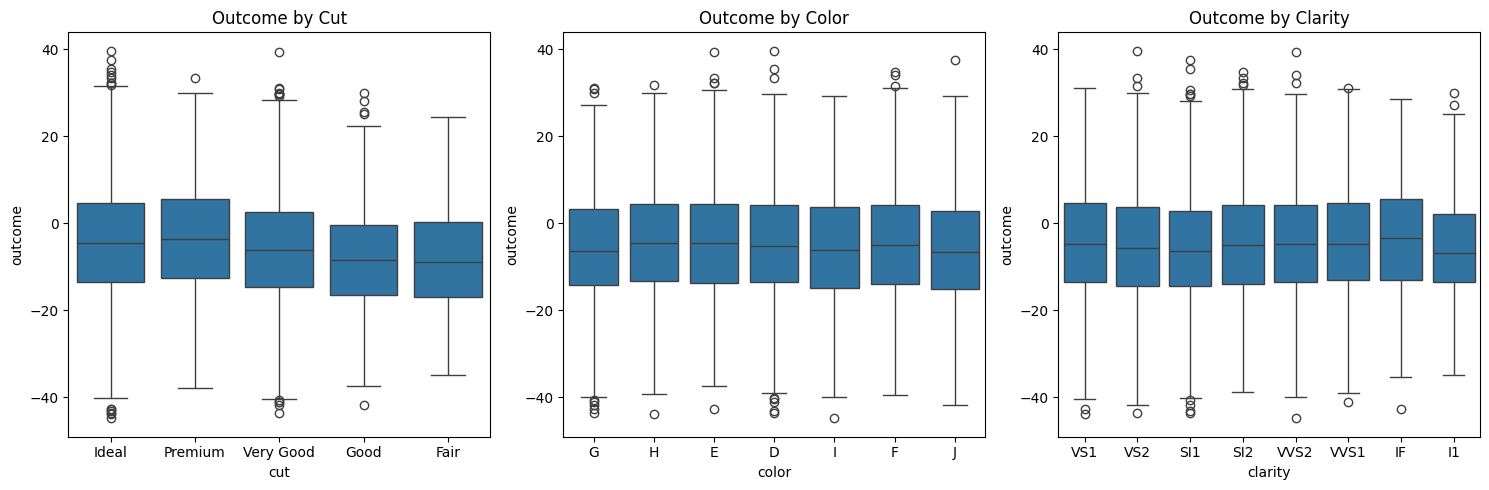

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x="cut", y="outcome", data=df, ax=axes[0])
axes[0].set_title("Outcome by Cut")

sns.boxplot(x="color", y="outcome", data=df, ax=axes[1])
axes[1].set_title("Outcome by Color")

sns.boxplot(x="clarity", y="outcome", data=df, ax=axes[2])
axes[2].set_title("Outcome by Clarity")

plt.tight_layout()
plt.savefig("../figures/categorical_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()


One-hot encoding is going to be used as the medians are not comparable. Given if the labels like "Ideal", "Premium", "Good" are ordinal, one-hot encoding will be used.

## 7. Feature Scale and Skewness

In [133]:
df.describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
outcome,-4.979081,12.722224,-44.879471,39.675966
carat,0.798407,0.472046,0.200000,4.000000
depth,61.748060,1.429631,50.800000,70.500000
table,57.467360,2.247036,44.000000,73.000000
price,3910.841900,3940.369616,326.000000,18791.000000
x,5.733974,1.114850,0.000000,10.010000
y,5.741665,1.228057,0.000000,58.900000
z,3.540757,0.692502,0.000000,8.060000
a1,0.502349,0.291012,0.000128,0.999789
a2,0.507509,0.291207,0.000101,0.999976


In [134]:
numerical_features = df.select_dtypes(include="number").columns
df[numerical_features].skew().sort_values(ascending=False)

y          8.372088
price      1.633379
carat      1.153380
table      0.721103
x          0.373087
z          0.364712
outcome    0.083080
b10        0.019527
b5         0.012293
b6         0.007632
a5         0.007531
b3         0.003986
b2         0.000515
a6        -0.000117
b1        -0.000258
a3        -0.003662
b4        -0.007648
b9        -0.009831
a1        -0.010857
a10       -0.015344
a4        -0.019157
a9        -0.020444
a2        -0.027996
a7        -0.033658
b8        -0.034361
a8        -0.034436
b7        -0.058334
depth     -0.230483
dtype: float64

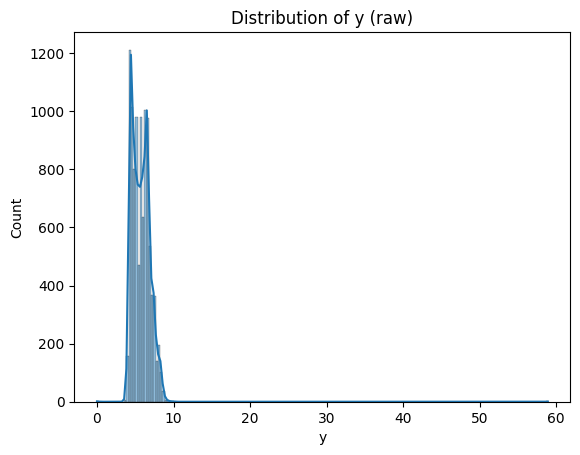

In [135]:
sns.histplot(df["y"], kde=True)
plt.title("Distribution of y (raw)")
plt.savefig("../figures/y_distribution_with_outlier.png", dpi=300, bbox_inches="tight")
plt.show()

Removed 5 rows due to invalid dimensions.


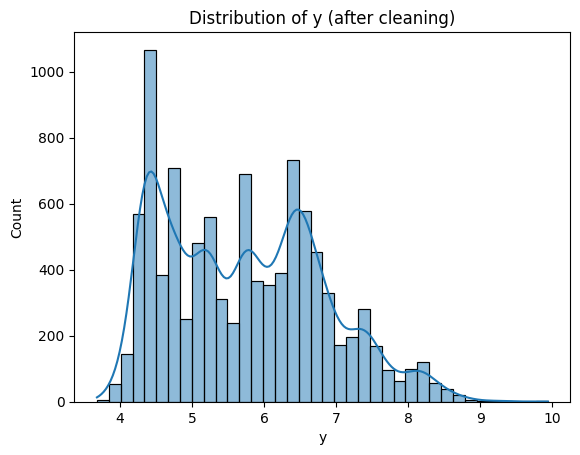

In [136]:
df_clean = df[(df["y"] <= 10) & (df["x"] > 0) & (df["z"] > 0)]
print(f"Removed {len(df) - len(df_clean)} rows due to invalid dimensions.")

sns.histplot(df_clean["y"], kde=True)
plt.title("Distribution of y (after cleaning)")
plt.savefig("../figures/y_distribution_without_outlier.png", dpi=300, bbox_inches="tight")
plt.show()

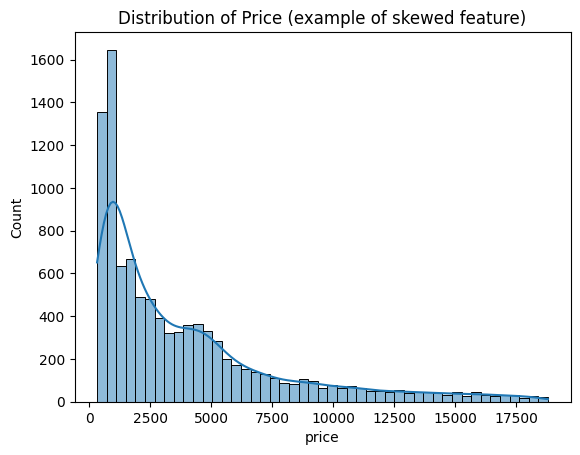

In [137]:
sns.histplot(df["price"], kde=True)
plt.title("Distribution of Price (example of skewed feature)")
plt.savefig("../figures/price_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. EDA Conclusions and Preprocessing Plan

- The outcome variable is approximately symmetric (skew ≈ 0.08), so no transformation is required.
- Rows containing impossible physical dimensions (x, y, z = 0) and an extreme y outlier were removed as data errors.
- Strong multicollinearity exists between carat, price, x, y, and z; regularization or feature selection will be considered.
- Depth shows the strongest monotonic relationship with outcome and is likely a key predictor.
- Categorical features (cut, color, clarity) contain predictive information and will be one-hot encoded.
- Several numerical features (price, carat, table) are right-skewed and may benefit from log transformation.
- All numerical features will be scaled prior to modelling.